#### Please upvote if you find the notebook useful :)

#### If you are new to LightAutoML, [here](https://www.kaggle.com/c/tabular-playground-series-apr-2021/discussion/231090) is the explanation discussion topic

#### In this notebook we try to incorporate features from [this notebook](https://www.kaggle.com/jmargni/tps-apr-2021-lightgbm-cv) to our LightAutoML solution to show how it can be done in real ML tasks.
#### To make difference inside pseudolabelling process we also added Catboost algo with params from [this](https://www.kaggle.com/belov38/catboost-lb) notebook

### The main idea of this kernel is pseudolabelling the test data (described in details [here](https://www.kaggle.com/c/tabular-playground-series-apr-2021/discussion/231738)) and building model using our opensourced framework [LightAutoML](https://github.com/sberbank-ai-lab/LightAutoML).

# Step 0.0. Install LightAutoML

In [1]:
!pip install -U lightautoml

     |████████████████████████████████| 249 kB 1.3 MB/s 
     |████████████████████████████████| 1.2 MB 5.3 MB/s 
     |████████████████████████████████| 424 kB 7.0 MB/s 
     |████████████████████████████████| 204 kB 6.8 MB/s 
     |████████████████████████████████| 232 kB 7.3 MB/s 
     |████████████████████████████████| 2.8 MB 7.3 MB/s 
     |████████████████████████████████| 93 kB 1.2 MB/s 
     |████████████████████████████████| 121 kB 11.2 MB/s 
     |████████████████████████████████| 84 kB 2.2 MB/s 
     |████████████████████████████████| 89 kB 4.5 MB/s 
     |████████████████████████████████| 90 kB 4.8 MB/s 
     |████████████████████████████████| 96 kB 3.2 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=e645e7bae37c10762829e8719a859e1334bfb9d4376631e07c7f387fbd4cfe1c
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for json2html: file

# Step 0.1. Import necessary libraries 

In [2]:
%matplotlib inline

# Standard python libraries
import os
import time
import re

# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt

# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task
from lightautoml.utils.profiler import Profiler

# Step 0.2. Parameters 

In [3]:
N_THREADS = 4 # threads cnt for lgbm and linear models
N_FOLDS = 10 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 3*3600 # Time in seconds for automl run

# Step 0.3. Fix torch number of threads and numpy seed 

In [4]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

# Step 0.4. Data load 

In [5]:
%%time

train_data = pd.read_csv('../input/loading-other-data-for-tps-apr/balanced_dataset.csv')
train_data.head()

CPU times: user 601 ms, sys: 74 ms, total: 675 ms
Wall time: 1.04 s


,Pclass,Age,SibSp,Parch,Fare,Name,Ticket,Sex,Cabin_A,Cabin_B,...,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,Embarked_C,Embarked_Q,Embarked_S,Embarked_X,Survived
0,-1.425730,-4.307127e-16,1.901268,-0.505478,0.134351,17441,49,1,0,0,...,0,0,0,0,0,0,0,1,0,1
1,0.877699,-4.307127e-16,-0.539572,-0.505478,-0.533837,3063,49,1,0,0,...,0,0,0,0,1,0,0,1,0,0
2,0.877699,-2.069149e+00,0.680848,1.628715,1.070483,17798,14,1,0,0,...,0,0,0,0,1,0,0,1,0,0
3,0.877699,-9.374220e-01,-0.539572,-0.505478,-0.555506,12742,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
4,0.877699,-5.737175e-01,-0.539572,-0.505478,-1.023540,2335,49,1,0,0,...,0,0,0,0,1,0,0,1,0,1


In [6]:
test_data = pd.read_csv('../input/loading-other-data-for-tps-apr/test.csv')
test_data.head()

,Pclass,Age,SibSp,Parch,Fare,Name,Ticket,Sex,Cabin_A,Cabin_B,...,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,Embarked_C,Embarked_Q,Embarked_S,Embarked_X
0,0.877699,-0.937422,-0.539572,-0.505478,0.949786,10830,49,1,0,0,...,0,0,0,0,0,1,0,0,1,0
1,0.877699,1.123570,-0.539572,-0.505478,-1.273379,17134,49,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,-1.425730,-0.937422,-0.539572,-0.505478,0.481059,9978,49,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,-0.274016,-0.573717,-0.539572,-0.505478,-0.563310,13303,49,1,0,0,...,0,0,0,0,0,1,0,0,1,0
4,-1.425730,-1.058657,-0.539572,1.628715,0.125497,4406,49,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [7]:
submission = pd.read_csv('../input/tabular-playground-series-apr-2021/sample_submission.csv')
submission.head()

,PassengerId,Survived
0,100000,1
1,100001,1
2,100002,1
3,100003,1
4,100004,1


In [8]:
# # Now we use our almost best submission
# pseudo_label_test = pd.read_csv('../input/n3-tps-april-21-lightautoml-starter/LightAutoML_compose_version_25.csv')
# pseudo_label_test

In [9]:
# test_data['Survived'] = pseudo_label_test['Survived'].values

# Step 0.5. Add new features

#### Important note: below we can see new features creation from [this notebook](https://www.kaggle.com/jmargni/tps-apr-2021-lightgbm-cv) but I have deleted all NaNs filling if they don't use test data to do it

In [10]:
#ref.: https://www.kaggle.com/jmargni/tps-apr-2021-lightgbm-cv

def create_extra_features(data):
    # Age fillna with mean age for each class
    age_map = data[['Age', 'Pclass']].dropna().groupby('Pclass').mean().to_dict()
    data.Age = data.Age.fillna(data.Pclass.map(age_map['Age']))

    # Cabin, fillna with 'X' and take first letter
    data.Cabin = data.Cabin.map(lambda x: str(x)[0].strip())

    # Ticket, fillna with 'X', split string and take first split 
    data.Ticket = data.Ticket.map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else 'X')

    # Fare, fillna with mean value 
    # (THE ONLY FILLNA LEFT BECAUSE HERE WE USE TEST DATASET - LightAutoML can't do it in real life because of strict distinction between train and test stages)
    data.Fare = data.Fare.fillna(data.Fare.mean())

    # Embarked, fillna with 'X' value
    #all_df.Embarked = all_df.Embarked.fillna('X')
    
    # Name, take only surnames
    #data.Name = data.Name.map(lambda x: str(x).split(',')[0])
       
    # let's leave this features here to use after receiving plateau from pseudolabelling
    
    data['FirstName'] = data.Name.map(lambda x: str(x).split(',')[0])
    data['Surname'] = data.Name.map(lambda x: str(x).split(',')[1])
    
    for col in ['Name', 'FirstName', 'Surname']:
        data['Counter_' + col] = data[col].map(data.groupby(col)['PassengerId'].count().to_dict())
        
    data.drop(columns = ['Name', 'Surname'], inplace = True)

    
    return data


In [11]:
all_df = train_data
# all_df = create_extra_features(all_df)
# train_data, test_data = all_df[:len(train_data)], all_df[len(train_data):]
print(train_data.shape, test_data.shape)

(245436, 22) (100000, 21)


# ========= AutoML preset usage =========


# Step 1. Create Task

In [12]:
%%time
def acc_score(y_true, y_pred, **kwargs):
    return accuracy_score(y_true, (y_pred > 0.5).astype(int), **kwargs)

def roc_auc_metric(y_true, y_pred, sample_weight, **kwargs):
    mask = (sample_weight > 1)
    return roc_auc_score(y_true[mask], y_pred[mask])

task = Task('binary', metric = roc_auc_metric, greater_is_better=True)

CPU times: user 1.06 ms, sys: 8 µs, total: 1.06 ms
Wall time: 1.07 ms


# Step 2. Setup columns roles

In [13]:
# Add weights for metric calculation only by true targets
# all_df['weight'] = [1.01] * len(train_data) + [0.99] * len(test_data)

In [14]:
%%time

roles = {
    'target': 'Survived'
     # To calculate metric only on real targets
}

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11.9 µs


# Step 3. Train on full data (train + pseudolabeled by best submission test) using multistart with different seed and predict on test data

As we currently have a bug in TabularUtilizedAutoML with specific configs setup (it will be fixed in the next release), we will use simple for cycle by random states to do the job. 

In [15]:
params = {
    'metric': 'binary_logloss',
    'n_estimators': 10000,
    'objective': 'binary',
    'learning_rate': 0.02,
    'min_child_samples': 150,
    'reg_alpha': 3e-5,
    'reg_lambda': 9e-2,
    'num_leaves': 20,
    'max_depth': 16,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'subsample_freq': 2,
    'max_bin': 240
}

cb_params = {
    'max_depth':6,
    'max_ctr_complexity': 5,
    'num_trees': 50000,
    'od_wait': 500,
    'od_type':'Iter', 
    'learning_rate': 0.04,
    'min_data_in_leaf': 3
}

In [16]:
%%time 

cnt_trained = 0
results = []
for it, rs in enumerate(range(2000, 2015)):
    print('=' * 30)
    print('START RANDOM_STATE = {}'.format(rs))
    print('=' * 30)
    
    # Train AutoML
    automl = TabularAutoML(task = task, 
                           timeout = TIMEOUT,
                           cpu_limit = N_THREADS,
                           general_params = {'use_algos': [['linear_l2', 'lgb', 'cb']]},
                           selection_params = {'mode': 0},
                           reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': rs},
                           lgb_params = {'default_params': params, 'freeze_defaults': True},
                           cb_params = {'default_params': cb_params, 'freeze_defaults': True})
    
    oof_pred = automl.fit_predict(all_df, roles = roles)
    
    # Predict on test
    test_pred = automl.predict(test_data)
    cnt_trained += 1
    
    # Save predictions
    if it == 0:
        oof_pred_full = oof_pred.data[:, 0].copy()
        test_pred_full = test_pred.data[:, 0].copy()
    else:
        oof_pred_full += oof_pred.data[:, 0]
        test_pred_full += test_pred.data[:, 0]
    
    # Check scores for current predict and aggregated one
    acc_usual = acc_score(train_data['Survived'].values, oof_pred.data[:len(train_data), 0])
    acc_full = acc_score(train_data['Survived'].values, oof_pred_full[:len(train_data)] / cnt_trained)
    results.append((acc_usual, acc_full, acc_full - acc_usual))
    
    print('Check scores...')
    print('OOF score: {}'.format(acc_usual))
    print('OOF score full: {}'.format(acc_full))
    print('Difference: {}'.format(acc_full - acc_usual))

START RANDOM_STATE = 2000
Start automl preset with listed constraints:
- time: 10800 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (245436, 22)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 10769.80232000351 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====



Model Lvl_0_Pipe_0_Mod_0_LinearL2 failed during ml_algo.fit_predict call.

'>' not supported between instances of 'NoneType' and 'int'


AssertionError: Pipeline finished with 0 models for some reason.
Probably one or more models failed

# Step 4. Graphic check for received results

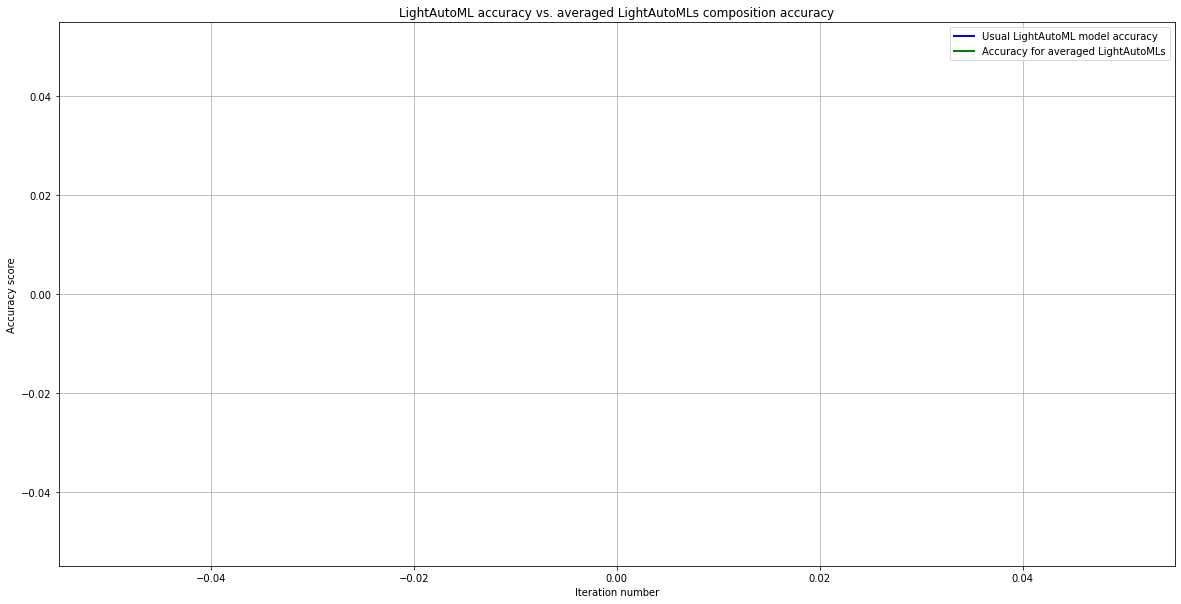

In [17]:
plt.figure(figsize = (20, 10))
plt.plot(range(1, cnt_trained + 1), [res[0] for res in results], color = 'b', linewidth = 2, label = 'Usual LightAutoML model accuracy')
plt.plot(range(1, cnt_trained + 1), [res[1] for res in results], color = 'g', linewidth = 2, label = 'Accuracy for averaged LightAutoMLs')
plt.grid()
plt.legend()
plt.title('LightAutoML accuracy vs. averaged LightAutoMLs composition accuracy')
plt.xlabel('Iteration number')
plt.ylabel('Accuracy score')
plt.show()

In [18]:
mean_acc = np.mean([res[0] for res in results])
mean_acc

nan

In [19]:
differences = np.array([res[1] - mean_acc for res in results])

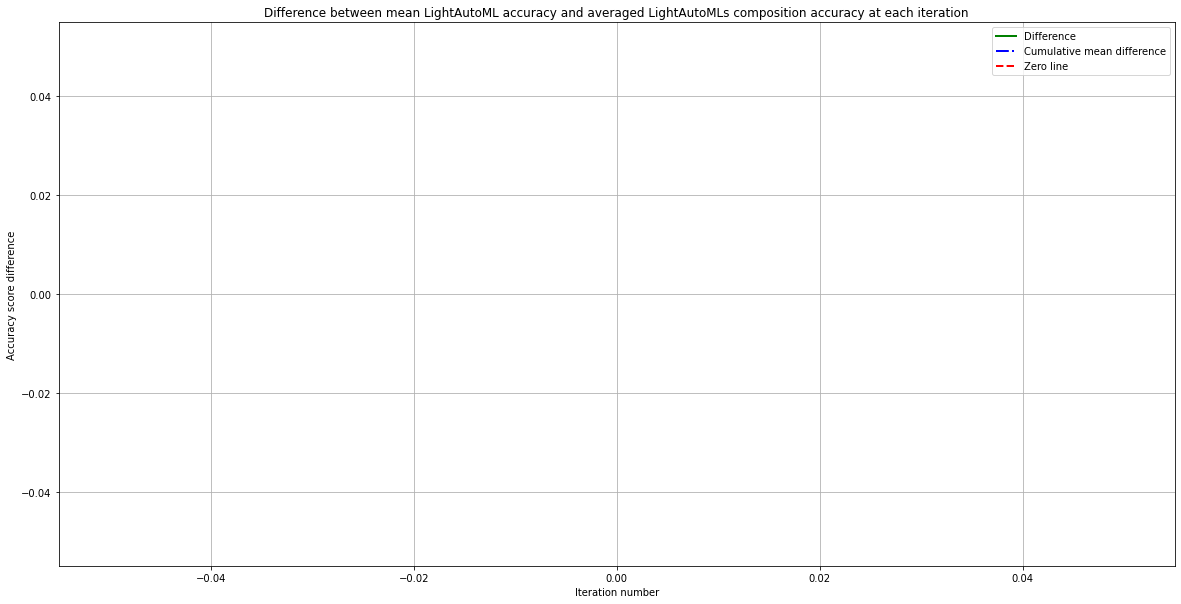

In [20]:
plt.figure(figsize = (20, 10))
plt.plot(range(1, cnt_trained + 1), differences, color = 'g', linewidth = 2, label = 'Difference')
plt.plot(range(1, cnt_trained + 1), [np.mean(differences[0:i+1]) for i in range(len(differences))], 'b-.', linewidth = 2, label = 'Cumulative mean difference')
plt.plot(range(1, cnt_trained + 1), [0.0 for res in results], 'r--', linewidth = 2, label = 'Zero line')
plt.grid()
plt.legend()
plt.title('Difference between mean LightAutoML accuracy and averaged LightAutoMLs composition accuracy at each iteration')
plt.xlabel('Iteration number')
plt.ylabel('Accuracy score difference')
plt.show()

#### Everything ok, we are above zero line and cumulative mean difference in scores is growing :)

# Step 5. Prepare submission

In [21]:
submission['Survived'] = ((test_pred_full / cnt_trained) > 0.5).astype(int)
submission.to_csv('LightAutoML_compose_version_1.csv', index = False)

NameError: name 'test_pred_full' is not defined

In [22]:
submission['Survived'].mean()

1.0